In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import random

In [0]:
train_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/training.json"
test_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/test.json"
with open(train_json, "r") as read_file:
  train_data = json.load(read_file)
with open(test_json, "r") as read_file:
  test_data = json.load(read_file)

In [4]:
print(len(train_data))
print(len(test_data))

1208
120


In [5]:
print(train_data[0].keys())
print(train_data[0]['image'].keys())
print(train_data[0]['image']['checksum'])
print(train_data[0]['image']['pathname'])
print(train_data[0]['image']['shape'])
print(len(train_data[1]['objects']))
print(train_data[0]['objects'][0].keys())
print(train_data[0]['objects'][0]['bounding_box'].keys())
print(train_data[0]['objects'][0]['bounding_box']['minimum'])
print(train_data[0]['objects'][0]['bounding_box']['maximum'])
print(train_data[0]['objects'][0]['category'])

dict_keys(['image', 'objects'])
dict_keys(['checksum', 'pathname', 'shape'])
676bb8e86fc2dbf05dd97d51a64ac0af
/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png
{'r': 1200, 'c': 1600, 'channels': 3}
61
dict_keys(['bounding_box', 'category'])
dict_keys(['minimum', 'maximum'])
{'r': 1057, 'c': 1440}
{'r': 1158, 'c': 1540}
red blood cell


True


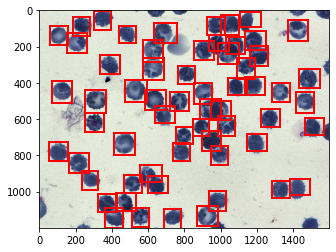

In [6]:
i = 1
cur_path = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/"
img_path = train_data[i]['image']['pathname']
print(os.path.isfile(cur_path + img_path))
img = cv2.imread(cur_path + img_path)

fig, ax = plt.subplots(1)
ax.imshow(img[:,:,::-1])
color_label = ['r', 'b', 'g', 'c', 'm', 'k', 'y']
for anno in train_data[i]['objects']:
  label = anno['category']
  rmin = anno['bounding_box']['minimum']['r']
  cmin = anno['bounding_box']['minimum']['c']
  rmax = anno['bounding_box']['maximum']['r']
  cmax = anno['bounding_box']['maximum']['c']
  w = rmax - rmin
  h = cmax - cmin
  rect = patches.Rectangle((cmin, rmin), w, h,
                            linewidth=2, edgecolor=color_label[0], facecolor='none')
  ax.add_patch(rect)

plt.show()

In [0]:
class_dict = {'red blood cell': 0, 'trophozoite': 1, 'schizont': 2, 'difficult': 3, 'ring': 4, 'leukocyte': 5, 'gametocyte': 6}

In [8]:
X_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_train.npy")
y_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_train.npy")
print(X_train.shape)
print(y_train.shape)

(80113, 32, 32, 3)
(80113, 1)


In [9]:
X_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_test.npy")
y_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_test.npy")
print(X_test.shape)
print(y_test.shape)

(5922, 32, 32, 3)
(5922, 1)


## **Model**


In [10]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
# ###data_dir = "./data/hymenoptera_data"

# # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "mobilenet"

# # Number of classes in the dataset
# num_classes = 7

# # Batch size for training (change depending on how much memory you have)
# batch_size = 8

# # Number of epochs to train for
# num_epochs = 15

# # Flag for feature extracting. When False, we finetune the whole model,
# #   when True we only update the reshaped layer params
# feature_extract = True

In [0]:
# def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
#     # Initialize these variables which will be set in this if statement. Each of these
#     #   variables is model specific.
#     model_ft = None
#     input_size = 0

#     if model_name == "resnet":
#         """ Resnet18
#         """
#         model_ft = models.resnet18(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
#         input_size = 224

#     elif model_name == "alexnet":
#         """ Alexnet
#         """
#         model_ft = models.alexnet(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "vgg":
#         """ VGG11_bn
#         """
#         model_ft = models.vgg11_bn(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "squeezenet":
#         """ Squeezenet
#         """
#         model_ft = models.squeezenet1_0(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#         model_ft.num_classes = num_classes
#         input_size = 224

#     elif model_name == "densenet":
#         """ Densenet
#         """
#         model_ft = models.densenet121(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
#         input_size = 224

#     elif model_name == "inception":
#         """ Inception v3
#         Be careful, expects (299,299) sized images and has auxiliary output
#         """
#         model_ft = models.inception_v3(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         # Handle the auxilary net
#         num_ftrs = model_ft.AuxLogits.fc.in_features
#         model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
#         # Handle the primary net
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs,num_classes)
#         input_size = 299

#     else:
#         print("Invalid model name, exiting...")
#         exit()

#     return model_ft, input_size

# # Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

In [0]:
__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self,
                 num_classes=7,
                 width_mult=1.0,
                 inverted_residual_setting=None,
                 round_nearest=8,
                 block=None):
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


def mobilenet_v2(pretrained=False, progress=True, **kwargs):
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

##Train

In [0]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable
from sklearn.metrics import classification_report, f1_score

In [17]:
batch_size = 32
validation_ratio = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class malaria_dataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.images = X
    self.labels = y
    self.transform = transform

  def __getitem__(self, index):
    img = self.images[index]
    label = self.labels[index]

    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.images)

In [19]:
split_point = int(np.floor(len(X_train) * validation_ratio))
indices = np.arange(len(X_train))
np.random.seed(10)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split_point:], indices[:split_point]

train_img = X_train[train_idx]
train_label = y_train[train_idx]
valid_img = X_train[valid_idx]
valid_label = y_train[valid_idx]
test_img = X_test
test_label = y_test

print("Train dataset")
print(train_img.shape)
print(train_label.shape)
for i in range(7):
  cur_idx = np.argwhere(train_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Valid dataset")
print(valid_img.shape)
print(valid_label.shape)
for i in range(7):
  cur_idx = np.argwhere(valid_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Test dataset")
print(test_img.shape)
print(test_label.shape)
for i in range(7):
  cur_idx = np.argwhere(test_label == i)
  print("{} label: {}".format(i, len(cur_idx)))
# train_img = torch.from_numpy(X_train[split_point:]).float().to(device)
# train_label = torch.from_numpy(y_train[split_point:]).float().to(device)
# valid_img = torch.from_numpy(X_train[:split_point]).float().to(device)
# valid_label = torch.from_numpy(y_train[:split_point]).float().to(device)
# test_img = torch.from_numpy(X_test).float().to(device)
# test_label = torch.from_numpy(y_test).float().to(device)
# print(train_img.size())
# print(train_label.size())
# print(valid_img.size())
# print(valid_label.size())
# print(test_img.size())
# print(test_label.size())

malaria_train = malaria_dataset(train_img, train_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_valid = malaria_dataset(valid_img, valid_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_test = malaria_dataset(test_img, test_label,
                               transform=transforms.Compose([transforms.ToTensor()]))

Train dataset
(72102, 32, 32, 3)
(72102, 1)
0 label: 69698
1 label: 1317
2 label: 165
3 label: 397
4 label: 308
5 label: 90
6 label: 127
Valid dataset
(8011, 32, 32, 3)
(8011, 1)
0 label: 7722
1 label: 156
2 label: 14
3 label: 44
4 label: 45
5 label: 13
6 label: 17
Test dataset
(5922, 32, 32, 3)
(5922, 1)
0 label: 5614
1 label: 111
2 label: 11
3 label: 5
4 label: 169
5 label: 0
6 label: 12


In [0]:
# def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
#     assert y_true.ndim == 1
#     assert y_pred.ndim == 1 or y_pred.ndim == 2
    
#     if y_pred.ndim == 2:
#         y_pred = y_pred.argmax(dim=1)
        
    
#     tp = (y_true * y_pred).sum().to(torch.float32)
#     tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
#     fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
#     fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
#     epsilon = 1e-7
    
#     precision = tp / (tp + fp + epsilon)
#     recall = tp / (tp + fn + epsilon)
    
#     f1 = 2* (precision*recall) / (precision + recall + epsilon)
#     f1.requires_grad = is_training
#     return f1

In [0]:
# Xception_model = mobilenet_v2()
# Xception_model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

# train_loader = torch.utils.data.DataLoader(
#     malaria_train, batch_size=batch_size
# )
# valid_loader = torch.utils.data.DataLoader(
#     malaria_valid, batch_size=batch_size
# )
# test_loader = torch.utils.data.DataLoader(
#     malaria_test, batch_size=batch_size, shuffle=False
# )

In [27]:
initial_lr = 0.001
num_epochs = 10

Xception_model = mobilenet_v2()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(Xception_model.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2436250
[1,   500] loss: 0.1701324
[1,   750] loss: 0.1764113
[1,  1000] loss: 0.1738744
[1,  1250] loss: 0.1493105
[1,  1500] loss: 0.1307691
[1,  1750] loss: 0.1428483
[1,  2000] loss: 0.1369635
[1,  2250] loss: 0.1201320
Training accuracy = 96.712%
0 label: Total=69698.0, correct=69150.0, acc=0.9921375075324973
1 label: Total=1317.0, correct=569.0, acc=0.43204252088078965
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=12.0, acc=0.030226700251889168
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.208


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.392%
0 label: Total=7722.0, correct=7656.0, acc=0.9914529914529915
1 label: Total=156.0, correct=61.0, acc=0.391025641025641
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=5.0, acc=0.11363636363636363
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.222
epoch 2
[2,   250] loss: 0.1253623
[2,   500] loss: 0.0996945
[2,   750] loss: 0.1200878
[2,  1000] loss: 0.1245758
[2,  1250] loss: 0.1074261
[2,  1500] loss: 0.0940135
[2,  1750] loss: 0.1048644
[2,  2000] loss: 0.1001867
[2,  2250] loss: 0.0880068
Training accuracy = 97.652%
0 label: Total=69698.0, correct=69484.0, acc=0.9969296106057562
1 label: Total=1317.0, correct=918.0, acc=0.6970387243735763
2 label: Total=165.0, correct=5.0, acc=0.030303030303030304
3 label: Total=397.0, correct=2.0, acc=0.005037783375314861
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, 

In [28]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.120%
0 label: Total=5614.0, correct=5568.0, acc=0.9918061987887424
1 label: Total=111.0, correct=58.0, acc=0.5225225225225225
2 label: Total=11.0, correct=4.0, acc=0.36363636363636365
3 label: Total=5.0, correct=2.0, acc=0.4
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=1.0, acc=0.08333333333333333
Test f1 score = 0.284


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

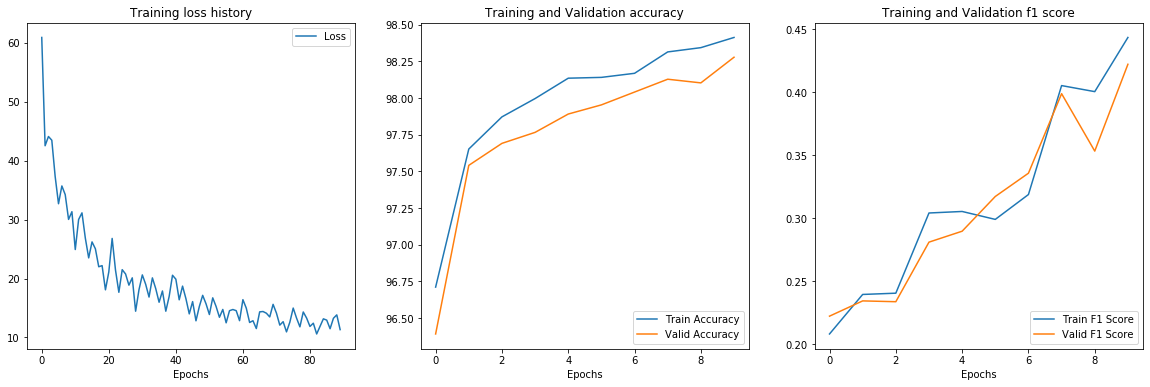

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

In [30]:
initial_lr = 0.0001
num_epochs = 10

Xception_model = mobilenet_v2()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2780119
[1,   500] loss: 0.1626632
[1,   750] loss: 0.1831632
[1,  1000] loss: 0.1870161
[1,  1250] loss: 0.1699689
[1,  1500] loss: 0.1566583
[1,  1750] loss: 0.1692119
[1,  2000] loss: 0.1600750
[1,  2250] loss: 0.1462684
Training accuracy = 96.695%
0 label: Total=69698.0, correct=69622.0, acc=0.9989095813366237
1 label: Total=1317.0, correct=83.0, acc=0.0630220197418375
2 label: Total=165.0, correct=1.0, acc=0.006060606060606061
3 label: Total=397.0, correct=13.0, acc=0.0327455919395466
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.166


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.380%
0 label: Total=7722.0, correct=7713.0, acc=0.9988344988344988
1 label: Total=156.0, correct=6.0, acc=0.038461538461538464
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=2.0, acc=0.045454545454545456
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.162
epoch 2
[2,   250] loss: 0.1436136
[2,   500] loss: 0.1235873
[2,   750] loss: 0.1378816
[2,  1000] loss: 0.1464104
[2,  1250] loss: 0.1337017
[2,  1500] loss: 0.1191515
[2,  1750] loss: 0.1222760
[2,  2000] loss: 0.1264456
[2,  2250] loss: 0.1066634
Training accuracy = 97.185%
0 label: Total=69698.0, correct=69456.0, acc=0.9965278774139861
1 label: Total=1317.0, correct=586.0, acc=0.44495064540622625
2 label: Total=165.0, correct=1.0, acc=0.006060606060606061
3 label: Total=397.0, correct=29.0, acc=0.07304785894206549
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0

In [31]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.204%
0 label: Total=5614.0, correct=5612.0, acc=0.9996437477734236
1 label: Total=111.0, correct=25.0, acc=0.22522522522522523
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=1.0, acc=0.2
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.202


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

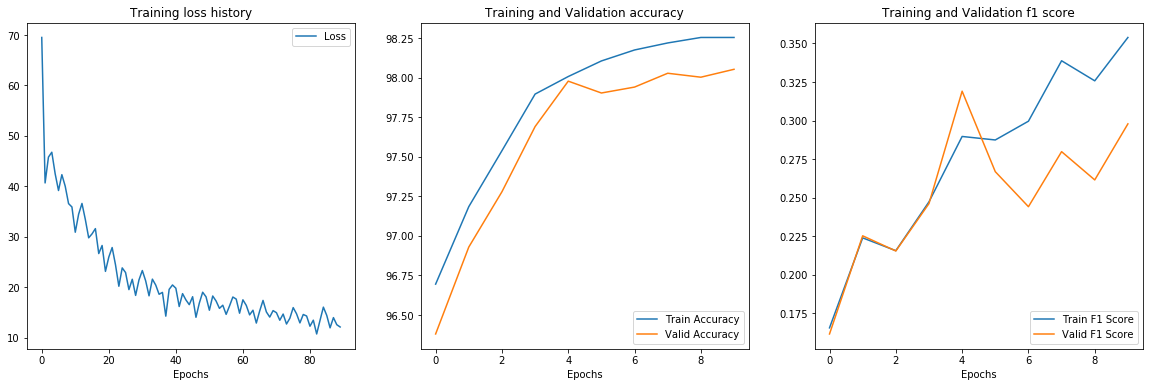

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

In [0]:

from torch.autograd import Variable

In [0]:
def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]


class FocalLoss(nn.Module):
    def __init__(self, num_classes=7):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        eps = 1e-8

        t = one_hot_embedding(y.data.cpu(), self.num_classes)
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, outputs, labels):
        loss = self.focal_loss_alt(outputs, labels)
        return loss

In [37]:
initial_lr = 0.0001
num_epochs = 10

Xception_model =  mobilenet_v2()
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 2.6423768
[1,   500] loss: 1.1902184
[1,   750] loss: 1.3307996
[1,  1000] loss: 1.2956880
[1,  1250] loss: 1.1033449
[1,  1500] loss: 1.0061140
[1,  1750] loss: 1.0704361
[1,  2000] loss: 1.0943821
[1,  2250] loss: 0.9872884
Training accuracy = 96.655%
0 label: Total=69698.0, correct=69638.0, acc=0.9991391431604925
1 label: Total=1317.0, correct=52.0, acc=0.039483675018982534
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.151


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.417%
0 label: Total=7722.0, correct=7718.0, acc=0.9994819994819995
1 label: Total=156.0, correct=6.0, acc=0.038461538461538464
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.150
epoch 2
[2,   250] loss: 1.0046322
[2,   500] loss: 0.8057067
[2,   750] loss: 0.9339832
[2,  1000] loss: 0.9387458
[2,  1250] loss: 0.8586264
[2,  1500] loss: 0.7747019
[2,  1750] loss: 0.8007524
[2,  2000] loss: 0.8457811
[2,  2250] loss: 0.7518474
Training accuracy = 97.074%
0 label: Total=69698.0, correct=69532.0, acc=0.9976182960773623
1 label: Total=1317.0, correct=460.0, acc=0.3492786636294609
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0

In [38]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 96.032%
0 label: Total=5614.0, correct=5594.0, acc=0.9964374777342359
1 label: Total=111.0, correct=91.0, acc=0.8198198198198198
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=1.0, acc=0.2
4 label: Total=169.0, correct=1.0, acc=0.005917159763313609
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

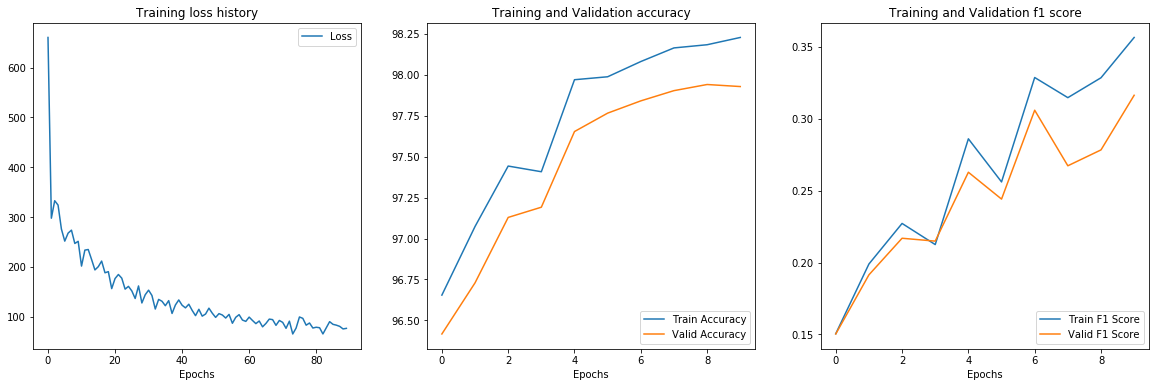

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

In [41]:
initial_lr = 0.000001
num_epochs = 10

Xception_model = mobilenet_v2()
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(Xception_model.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 1.7008113
[1,   500] loss: 1.3687131
[1,   750] loss: 1.1127545
[1,  1000] loss: 0.9225878
[1,  1250] loss: 0.7717850
[1,  1500] loss: 0.6544419
[1,  1750] loss: 0.5824856
[1,  2000] loss: 0.5165748
[1,  2250] loss: 0.4687321
Training accuracy = 96.666%
0 label: Total=69698.0, correct=69698.0, acc=1.0
1 label: Total=1317.0, correct=0.0, acc=0.0
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.392%
0 label: Total=7722.0, correct=7722.0, acc=1.0
1 label: Total=156.0, correct=0.0, acc=0.0
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.4272529
[2,   500] loss: 0.3849332
[2,   750] loss: 0.3785358
[2,  1000] loss: 0.3704144
[2,  1250] loss: 0.3411950
[2,  1500] loss: 0.3142428
[2,  1750] loss: 0.3172857
[2,  2000] loss: 0.3029206
[2,  2250] loss: 0.2965322
Training accuracy = 96.666%
0 label: Total=69698.0, correct=69698.0, acc=1.0
1 label: Total=1317.0, correct=0.0, acc=0.0
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.140
Validation accuracy = 96.392%
0 lab

In [42]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 94.799%
0 label: Total=5614.0, correct=5614.0, acc=1.0
1 label: Total=111.0, correct=0.0, acc=0.0
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.162


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0, 'Epochs')

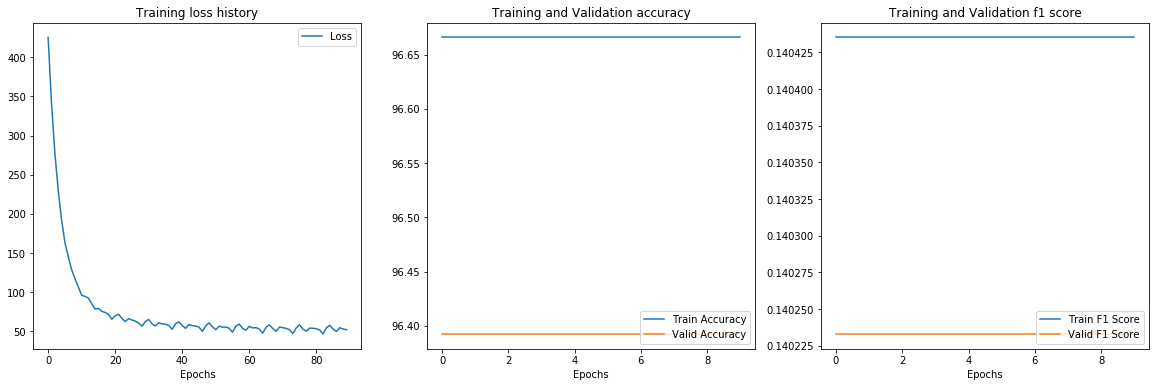

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

In [44]:
initial_lr = 0.0001
num_epochs = 10

Xception_model = mobilenet_v2()
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # # Horizontal Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(2)
        # # Vertical Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(3)
        # # 90 rotation
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3)
        # # or 270 rotation
        # elif torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 3.0113997
[1,   500] loss: 1.1666015
[1,   750] loss: 1.2576823
[1,  1000] loss: 1.2157241
[1,  1250] loss: 1.0991045
[1,  1500] loss: 0.9320403
[1,  1750] loss: 0.9720304
[1,  2000] loss: 0.9971994
[1,  2250] loss: 0.9078239
Training accuracy = 96.786%
0 label: Total=69698.0, correct=69531.0, acc=0.9976039484633705
1 label: Total=1317.0, correct=253.0, acc=0.1921032649962035
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=1.0, acc=0.0025188916876574307
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.178


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.293%
0 label: Total=7722.0, correct=7693.0, acc=0.9962444962444963
1 label: Total=156.0, correct=21.0, acc=0.1346153846153846
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.165
epoch 2
[2,   250] loss: 0.8414612
[2,   500] loss: 0.7227242
[2,   750] loss: 0.8119564
[2,  1000] loss: 0.8796108
[2,  1250] loss: 0.8412216
[2,  1500] loss: 0.6957645
[2,  1750] loss: 0.7342485
[2,  2000] loss: 0.7574835
[2,  2250] loss: 0.6776712
Training accuracy = 97.259%
0 label: Total=69698.0, correct=69440.0, acc=0.9962983155901174
1 label: Total=1317.0, correct=685.0, acc=0.5201214882308276
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=1.0, acc=0.0025188916876574307
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, c

In [45]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 94.664%
0 label: Total=5614.0, correct=5515.0, acc=0.9823655147844674
1 label: Total=111.0, correct=84.0, acc=0.7567567567567568
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=5.0, acc=0.029585798816568046
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

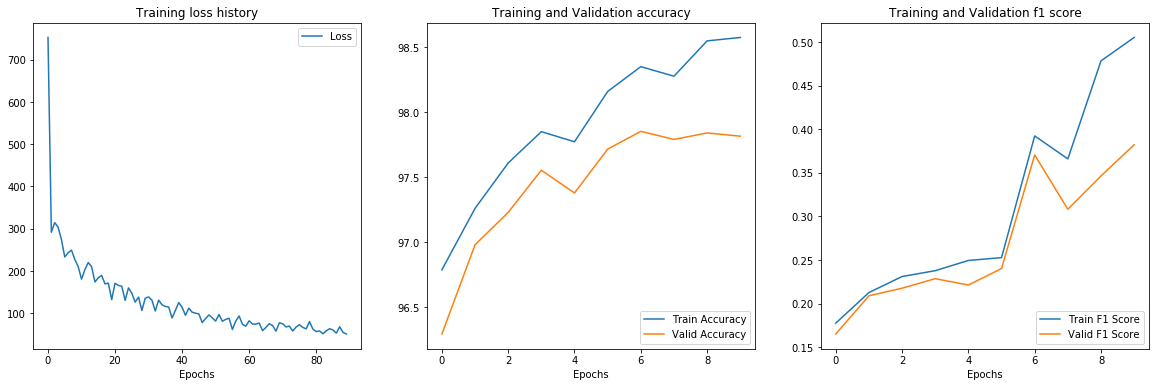

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")